# Focusing Data figure
Temporarily called figure 3. Could change. We want to smooth and plot bars with confidence intervals for the data in xixi's new experiments.
This file:
- takes a csv file with raw data
- reformats the data tidily
- normalizes the data
- creates the bootstrap function that randomly samples the data then fits a curve for each random sample
- takes the quantiles from the results of the bootstrap function to find the confidence interval
- creates an integrated data frame for the bar plots
- renormalizes the data for the bar plots
- plots everything above including smoothed curve and confidence intervals
- saves the figure

In [1]:
library(dplyr)
library(ggplot2)
library(cowplot)
library(magrittr)
library(tidyr)
library(broom)
library(splines)
library(stringr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract



# Figure 3, August 30 2016
Redoing figure 3 with Xixi's new data for focusing for Mannose, and using AMPCPP + the redos.
In the version below there is some issue with the mannose data being only integers in the original file.

## Data reformatting

In [2]:
fig3<- read.csv("../data/alldata_101916.csv")

To make this work the initial csv file data must be reformatted as follows:

In [3]:
tail(fig3)

,distance,dg,dg.ctrl,amppcp,amppcp.ctrl,mannose.ctrl,mannose,lg.ctrl,lg
161,302.1419,35.0,45,114.667,129.333,161.3333,137.5000,37.0000,44.0000
162,304.0303,33.5,45,108.667,131.667,160.5000,136.0000,39.6667,40.6667
163,305.9187,32.0,45,108.333,131.000,153.6667,135.3333,40.0000,41.3333
164,307.8071,31.5,44,107.000,131.333,142.0000,137.5000,39.0000,41.0000
165,309.6955,30.5,48,111.333,130.000,138.0000,128.6667,38.6667,40.3333
166,311.5839,29.5,45,108.000,133.000,134.5000,132.1667,36.3333,37.0000


In [ ]:
n<-dim(fig3)[1]
fig3<-fig3[1:(n-5),]

In [ ]:
tail(fig3) # making sure there are no trailing spaces. modify previous lines if there is

In [4]:
fig3 <- gather(fig3,"Experiment","Concentration",dg:lg) # putting the data in tidy format

In [5]:
head(fig3)

distance,Experiment,Concentration
0.0000,dg,28.0
1.8884,dg,29.5
3.7768,dg,30.5
5.6652,dg,31.0
7.5535,dg,32.0
9.4419,dg,32.5


## Data Normalizing

In [6]:
 normalit<-function(m){
     # this function will normalise the fluorescence intensities
   (m - min(m))*100/sum(m-min(m))
 }

In [7]:
# now we normalize all columns by experiment
fig3 %<>% group_by(Experiment) %>% mutate(Concentration.norm = normalit(Concentration))

In [8]:
# doing some regex to splot the columns accordingly
fig3$Substrate = NA
fig3$Substrate <- str_extract(fig3$Experiment, "[a-z]+")
fig3$Experiment <- str_match(fig3$Experiment, "[.]([a-z]+)")[,2]
fig3$Experiment[is.na(fig3$Experiment)] = "substrate"

In [9]:
fig3[200:210,]

distance,Experiment,Concentration,Concentration.norm,Substrate
62.3168,ctrl,47,0.4928131,dg
64.2052,ctrl,47,0.4928131,dg
66.0936,ctrl,48,0.5338809,dg
67.9819,ctrl,48,0.5338809,dg
69.8703,ctrl,48,0.5338809,dg
71.7587,ctrl,48,0.5338809,dg
73.6471,ctrl,49,0.5749487,dg
75.5355,ctrl,49,0.5749487,dg
77.4239,ctrl,50,0.6160164,dg
79.3123,ctrl,49,0.5749487,dg


In [10]:
# adding the three channels to our data
fig3$channel <- NA
fig3$channel[fig3$distance <= 100] <- 'left'
fig3$channel[fig3$distance > 100 & fig3$distance <= 220] <- 'center'
fig3$channel[fig3$distance > 220] <- 'right'
fig3$channel <- factor(fig3$channel, levels = c ('left','center','right'))

In [11]:
# transforming the experiment labels to factors so they will be plotted in order
fig3$Substrate <- factor(fig3$Substrate, levels = c ('dg','mannose','lg','amppcp'))

## Creating and running the bootstrap

In [12]:
# this function will run the bootstrap on all iterations of the data and fit the resulting bootstrapped
# data with a smooth curve
run_bootstrap <- function(df,m) {
    temp <- df %>%
        bootstrap(m) %>%
#          do(augment(glm(data = ., Concentration ~ ns(Distance, df = 6)),.))
         do(augment(loess(data = ., Concentration.norm ~ distance, span =0.6),.))
    temp
}

In [13]:
# this runs the bootstrap for a specified number of iterations

N_bootstrap = 500

fig3_bs <- fig3 %>%
    group_by(Substrate,Experiment) %>%
    do(run_bootstrap(., N_bootstrap))

## Calculating confidence intervals

In [14]:
# now that we have the bootstrap functions we can calculate the confidence interval
# this will allow us to plot error bars

alpha <- 0.05
fig3_recap <- fig3_bs %>%
    group_by(Experiment, Substrate, distance,channel) %>% 
    summarise(lo = quantile(.fitted,alpha/2), 
              hi = quantile(.fitted,1-alpha/2), 
              smooth = mean(.fitted), 
              orig = mean(Concentration.norm))
fig3_bs %<>% group_by(Experiment, Substrate, distance,channel) %>% 
    mutate(lo = quantile(.fitted,alpha/2), hi = quantile(.fitted,1-alpha/2))

## Creating integrated dataset for barplots and rescaling

In [15]:
# we create a new data frame with summed data by channel for the barplot

bychannel_recap <- fig3_recap %>% 
    group_by(channel,Substrate,Experiment) %>% 
    summarise(orig = sum(orig), smooth = sum(smooth), lo = sum(lo), hi = sum(hi))

In [16]:
# this is an intermediary step
# we determine the scale factor so that
# the CENTER channel of the CONTROL experiment for DG is 100

a <- bychannel_recap %>% filter(channel == 'center', Experiment == 'ctrl', Substrate == 'dg')
scale <- 100/a$smooth

In [17]:
# now we rescale the recapped data frame according to our scale factor

bychannel_recap <- bychannel_recap %>% mutate(orig = orig*scale, smooth = smooth*scale, lo = lo*scale,
                                              hi = hi*scale)

In [25]:
write.csv(bychannel_recap, "../data/bychannel_recap2.csv")

## Plotting

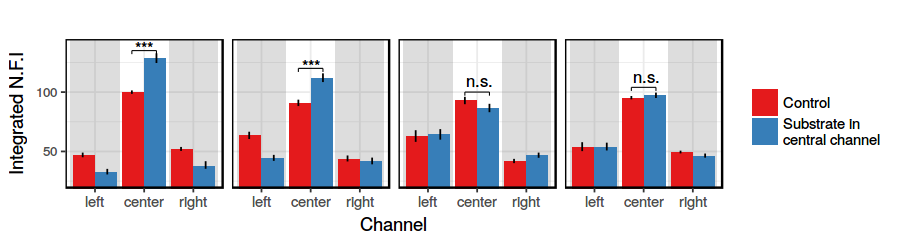

In [18]:
# PLOTTING THE BARPLOTS


options(repr.plot.width = 7.5, repr.plot.height = 2)
integrated <- ggplot(data = bychannel_recap, 
                     aes(x=channel, y= smooth,fill = Experiment)) + 
    geom_bar(stat = "identity",position = "dodge") +
    xlab("Channel") +
    ylab("Integrated N.F.I") +
    facet_grid(. ~ Substrate,
       labeller = labeller(Substrate =c(dg = 'D-Glucose/ATP',lg = 'L-Glucose/ATP', mannose = 'Mannose/ATP',
                                       amppcp = "D-Glucose/AMP-PCP"))) +
    theme_bw() +
    theme(panel.border = element_rect(size = .8, colour = "black"),
         axis.text.y = element_text(size=8),
         legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA),
         panel.grid.major = element_line()) + 
  annotate("rect", xmin = 0.5, xmax = 1.5, ymin = 0, ymax = 150, alpha = .2) +
   annotate("rect", xmin = 2.5, xmax = 3.5, ymin = 0, ymax = 150, alpha = .2) + 
    geom_bar(stat = "identity",position = "dodge") +
    geom_errorbar(aes(ymin = lo,ymax = hi ),position = position_dodge(1), width = 0) +
scale_fill_brewer(palette = 'Set1',labels = c("Control","Substrate in\ncentral channel")) +
coord_cartesian(ylim=c(25,139))
# MODIFY THE SCALE ABOVE AS NECESSARY

#################################
# data frame for annotation bar
#################################

ann.data <- data.frame(Substrate = c("dg","mannose","lg","amppcp"), Experiment = c("substrate","ctrl"), 
                      ann.x = c(0.75, 0.75), ann.xend = c(1.25,1.25), ann.y = c(0.0033, 0.0037),
                      ann.yend = c(0.0033,0.0037), ann.text = c("***","***"," n.s."," n.s."), 
                       ann.textoffset = c (2,2,9,9))

ann.data <- ann.data[rep(seq_len(nrow(ann.data)), each = 1),]
#ann.data$channel <- factor(c('left','center','right','left','center','right'), levels = c ('left','center','right'))
ann.data$channel <- factor(c('left'))
#order is DG l,c,r LG l,c,r
ann.data$x.offset <- c(1,1,1,1)

# MODIFY THIS FOR THE HEIGHT OF THE BRACKETS
ann.data$y.offset <- c(135,120,100,104)


integrated <- integrated + 
    geom_segment(data = ann.data, size=.3,
                 aes(x = ann.x+x.offset, y=ann.y+y.offset, xend=ann.xend+x.offset, yend=ann.yend+y.offset)) +
    geom_segment(data = ann.data, size = .3,
                 aes(x = ann.x+x.offset,xend=ann.x+x.offset,y=ann.y-3+y.offset,yend=ann.y+y.offset)) +
    geom_segment(data = ann.data, size =.3,
                 aes(x = ann.xend+x.offset,xend=ann.xend+x.offset,y=ann.y-3+y.offset,yend=ann.y+y.offset)) +
    geom_text(data = ann.data, size= 3.5,
              aes(x = ann.x+.25+x.offset, y = ann.y+ann.textoffset+y.offset,label = ann.text))
                
print(integrated)

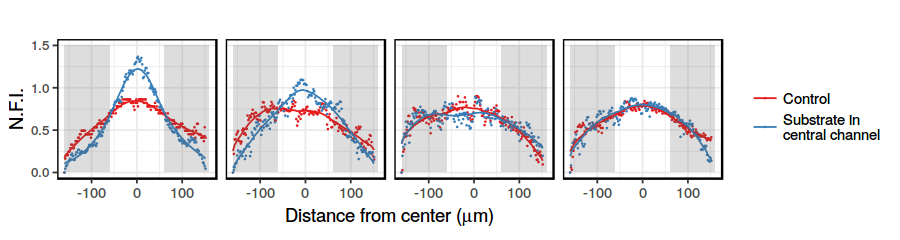

In [19]:
# PLOTTING THE CURVES

options(repr.plot.width = 7.5, repr.plot.height = 2)

raw <- ggplot(data = filter(fig3_recap),aes(x = distance-160,color = Experiment)) + 
    geom_point(aes(y = orig), size = 0.1) +
    geom_line(aes(y = smooth)) +
    ylab("N.F.I.") +
    xlab(expression(paste("Distance from center (", mu, "m)", sep = ""))) +
    facet_grid(. ~ Substrate,
               labeller = labeller(Substrate =c(dg = 'D-Glucose/ATP',lg = 'L-Glucose/ATP', mannose = 'Mannose/ATP',
                                       amppcp = "D-Glucose/AMP-PCP"))) +
    theme_bw() +     
    theme(panel.border = element_rect(size = 0.8, colour = "black"),
        axis.text.y = element_text(size=8),
        legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA)) +
    annotate("rect", xmin = -160, xmax = -60, ymin = 0.00002, ymax = +1.5, alpha = .2) +
    annotate("rect", xmin = 60, xmax = 160, ymin = 0.00002, ymax = +1.5, alpha = .2) +
scale_color_brewer(palette = 'Set1',labels = c("Control","Substrate in\ncentral channel")) +
coord_cartesian(ylim=c(0,1.5))

    
print(raw)

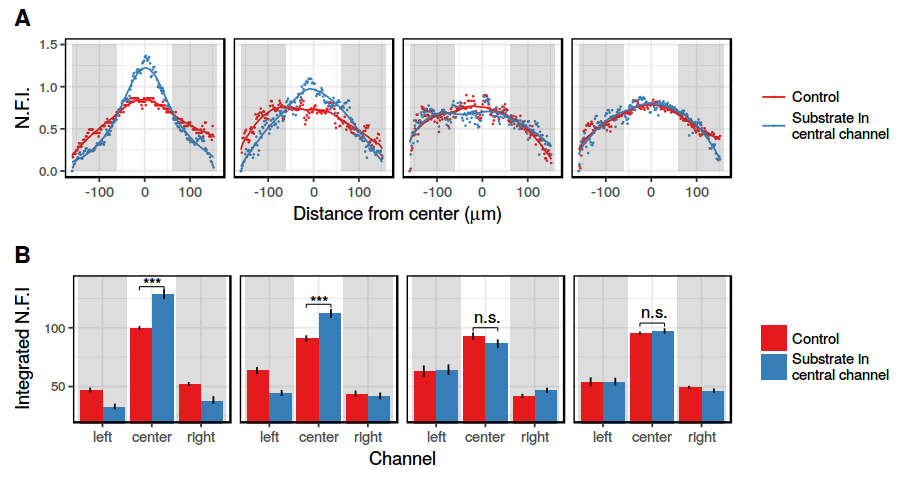

In [20]:
# PLOTTING THE FINAL FIGURE

options(repr.plot.width = 7.6, repr.plot.height = 4)

plot_grid(raw,integrated, labels = c("A","B"),ncol = 1)

In [ ]:
# saving the final figure

ggsave("../img/FocusingExperimentPlot_v8.png",width = 7.6, height = 4)

## Bonus: focusing with time

In [ ]:
time_data <- read.csv("../newdata/time_data.csv")

In [ ]:
head(time_data)

In [ ]:
#time_data %<>% gather('Experiment', 'Concentration', focusing:control)
#time_data$Experiment = factor(time_data$Experiment, c("control",'focusing'))

In [ ]:
options(repr.plot.width = 2.5, repr.plot.height = 2)

time_plot <- ggplot(data=time_data, aes(x=time,y=focusing, color)) + geom_point() +
    geom_line() +
    geom_errorbar(aes(ymin=focusing-err,ymax=focusing+err), width = .1) +
scale_color_brewer(palette = 'Set1',labels = c("Control","Substrate in\ncentral channel")) +
theme_bw() +
 ylab("Integrated N.F.I.") +
    xlab("Time (mn)") +
    theme(panel.border = element_rect(size = .8, colour = "black"),
         axis.text.y = element_text(size=8),
         legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA),
         panel.grid.major = element_line())

print(time_plot)

In [ ]:
ggsave("../img/Focusing_Time_v2.png",width = 2.5, height = 2)